# 0. 环境准备

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 设置pandas可以显示的行数和列数
pd.options.display.max_rows = 400
pd.options.display.max_columns = None

# 忽略warnings
import warnings
warnings.filterwarnings("ignore")

#推荐安装插件： nbextensions

# 1.读入数据

In [2]:
# store:门店编号
# dept: 商品部门编号
# week: 每周周一的日期 
# sales: 销售金额
df_sales = pd.read_csv('data/store_sales.csv', parse_dates=['week'])
df_sales.head(2)

,store,dept,week,sales
0,1,1,2010-02-01,24924.50
1,1,1,2010-02-08,46039.49


In [3]:
# store:门店编号
# dept: 商品部门编号
# week: 每周周一的日期 
# promotion_sales: 促销活动带来的销售金额
df_promotion = pd.read_csv('data/promotion_data.csv', parse_dates=['week'])
df_promotion.head(2)

,store,dept,week,promotion_sales
0,1,1,2010-02-08,22538.074165
1,1,1,2010-02-15,18381.721909


In [4]:
# 合并销售和促销数据
df_all = pd.merge( df_sales, df_promotion, how='left' )
df_all.fillna(0, inplace=True)

# 使用prophet算法做预测

In [5]:
import prophet

Importing plotly failed. Interactive plots will not work.


## 预测1号店的1号部门， 以2012-07-30以前的数据做训练，往后预测一周

In [6]:
# 数据准备
df_train = df_all[ (df_all['week']<='2012-07-30') & 
                 (df_all['store']==1) & 
                 (df_all['dept']==1)]
#使用prophet前，要将日期字段重命名为”ds", 预测对象重命名为"y"
df_train.rename(columns={'week':'ds','sales':'y'},inplace=True)

df_test = df_all[(df_all['week']=='2012-08-06') &
                (df_all['store']==1) & 
                (df_all['dept']==1)]
df_test.rename(columns={'week':'ds','sales':'y'},inplace=True)

In [7]:
#训练模型
m = prophet.Prophet(yearly_seasonality=True)
m.add_regressor( 'promotion_sales' )
m.fit( df_train )

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


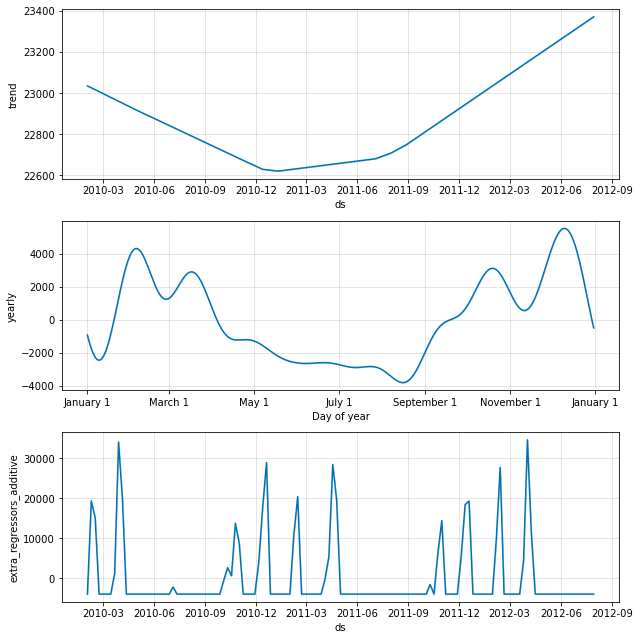

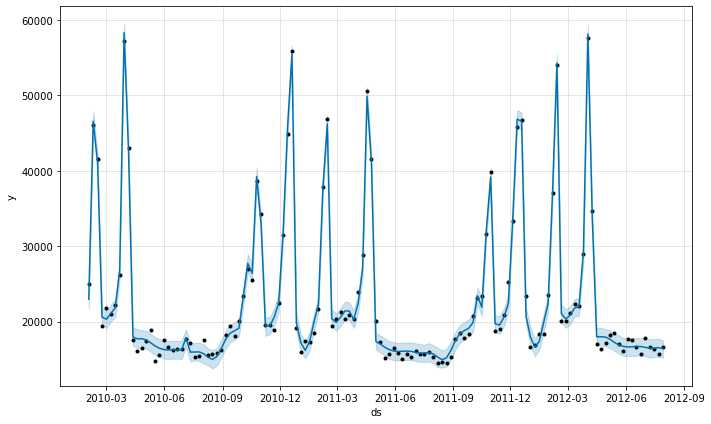

In [8]:
#  拟合历史的数据
df_fit = m.predict( df_train )

# 可视化拟合结果
fig1 = m.plot_components(df_fit)
fig2 = m.plot( df_fit )

In [9]:
# 预测未来的数据
df_predict = m.predict( df_test )
df_test['yhat'] = df_predict['yhat'].values

## 预测1号店的所有部门， 以2012-07-30以前的数据做训练，往后预测一周

In [10]:
dept_list = df_all[ df_all['store']==1 ]['dept'].unique()

all_result = []
for dept in dept_list:
    # 数据准备
    df_train = df_all[ (df_all['week']<='2012-07-30') & 
                      (df_all['store']==1) & 
                      (df_all['dept']==dept)]
    df_train.rename(columns={'week':'ds','sales':'y'},inplace=True)

    df_test = df_all[ (df_all['week']>'2012-07-30') & 
                     (df_all['week']<='2012-08-06') &
                     (df_all['store']==1) & 
                     (df_all['dept']==dept)]
    df_test.rename(columns={'week':'ds','sales':'y'},inplace=True)
    
    ## 只有超过两年的历史数据才能训练模型
    if (df_train.shape[0] > 100) & ( df_test.shape[0] > 0 ):
        #训练模型
        m = prophet.Prophet(yearly_seasonality=True)
        m.add_regressor( 'promotion_sales' )
        m.fit( df_train )

        #预测结果
        df_predict = m.predict( df_test )
        df_test['yhat'] = df_predict['yhat'].values

        all_result.append( df_test )
all_result =pd.concat( all_result )

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

# 使用lightGBM算法做预测

In [11]:
import lightgbm as lgb

## 预测1号店的1号部门， 以2012-07-30以前的数据做训练，往后预测一周

In [12]:
df_sample = df_all[ (df_all['store']==1) & 
                  (df_all['dept']==1)].sort_values('week')

In [13]:
# 特征构建
feature_cols = []

## 第一组特征： 历史数据最后一周的销量和促销活动的金额
df_sample['sales_lw'] = df_sample['sales'].shift(1)
df_sample['promotion_lw'] = df_sample['promotion_sales'].shift(1)
feature_cols = feature_cols + ['sales_lw', 'promotion_lw']

## 第二组特征： 上一个周期（即去年同一周）的销量和促销活动金额
df_sample['sales_ly'] = df_sample['sales'].shift(52)
df_sample['promotion_ly'] = df_sample['promotion_sales'].shift(52)
feature_cols = feature_cols + ['sales_ly', 'promotion_ly']

## 第三组特征：待预测周的促销活动金额
feature_cols = feature_cols + ['promotion_sales']

## 只保留所有特征都不为空的数据
for col in feature_cols:
    df_sample = df_sample[ ~df_sample[col].isna() ]

In [14]:
# 构建训练集和验证集
x_train = df_sample[ df_sample['week']<='2012-07-30' ][ feature_cols ].values
y_train = df_sample[ df_sample['week']<='2012-07-30' ][ 'sales' ].values

x_test = df_sample[ df_sample['week']=='2012-08-06' ][ feature_cols ].values
y_test = df_sample[ df_sample['week']=='2012-08-06'  ][ 'sales' ].values

In [15]:
# 使用lightGBM建模
from lightgbm.sklearn import LGBMRegressor

model = LGBMRegressor()
model.fit(x_train, y_train)

LGBMRegressor()

In [16]:
# 预测
y_pred = model.predict( x_test )

In [17]:
y_pred, y_test

(array([16165.25781465]), array([16119.92]))

## 预测1号店的所有部门， 以2012-07-30以前的数据做训练，往后预测一周

In [18]:
df_sample = df_all[ (df_all['store']==1)].sort_values(['dept','week'])

In [19]:
# 特征构建
feature_cols = []

## 第一组特征： 历史数据最后一周的销量和促销活动的金额
df_sample['sales_lw'] = df_sample.groupby(['dept'])['sales'].shift(1)
df_sample['promotion_lw'] = df_sample.groupby(['dept'])['promotion_sales'].shift(1)
feature_cols = feature_cols + ['sales_lw', 'promotion_lw']

## 第二组特征： 上一个周期（即去年同一周）的销量和促销活动金额
df_sample['sales_ly'] = df_sample.groupby(['dept'])['sales'].shift(52)
df_sample['promotion_ly'] = df_sample.groupby(['dept'])['promotion_sales'].shift(52)
feature_cols = feature_cols + ['sales_ly', 'promotion_ly']

## 第三组特征：待预测周的促销活动金额
feature_cols = feature_cols + ['promotion_sales']

## 只保留所有特征都不为空的数据
for col in feature_cols:
    df_sample = df_sample[ ~df_sample[col].isna() ]

In [20]:
# 构建训练集和验证集
x_train = df_sample[ df_sample['week']<='2012-07-30' ][ feature_cols ].values
y_train = df_sample[ df_sample['week']<='2012-07-30' ][ 'sales' ].values

x_test = df_sample[ df_sample['week']=='2012-08-06' ][ feature_cols ].values
y_test = df_sample[ df_sample['week']=='2012-08-06'  ][ 'sales' ].values

In [21]:
# 使用lightGBM建模
model = LGBMRegressor()
model.fit(x_train, y_train)

LGBMRegressor()

In [22]:
# 预测
y_pred = model.predict( x_test )

In [23]:
y_pred, y_test

(array([ 15827.41919404,  46492.69038445,  33816.23715648,  38767.89005671,
         18651.50044702,   3007.55989147,  15723.48993843,  36569.28449712,
         22201.31808872,  32237.02102998,  25665.66996911,  11427.83049287,
         39267.89433303,  12809.91590551,  23056.1242317 ,   9415.96940694,
           893.43898638,   4313.50313049,   6611.0256935 ,   7329.36145893,
         20837.83094154,   7810.59937471,   8883.57350279,   4828.58999793,
           956.34503643,    362.19617876,   4384.56222533,   3335.2270923 ,
          4473.93186268,   5600.11983861,   8499.64189403,  11254.18765046,
          1941.91176181,   1327.42045054,   2698.46876661,  71375.85983846,
         53906.44281667,    420.61066405,   8576.46688884,   4353.24002767,
         19717.37652578,    526.81136791,  13935.96711862,   1600.15559869,
           204.92894605,   8153.33735333,   1222.09211416,   2779.01344178,
           544.60686348,    860.24273607,   5682.3938113 ,   3256.49984248,
         397